## Project 2 : Predicting property price in 2017 Zillow data

19 January 2023

In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import LassoLars

from scipy import stats
from scipy.stats import pearsonr, spearmanr

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import SelectKBest, f_regression, RFE

from env import host, username, password, sql_connexion
import env

# import my functions
import project_2_acquire_zillow_function
import project_2_prepare_zillow_2017
import project_2_zillow_skbest_rfe_functions

# turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")


 &emsp;

## ACQUIRE & PREPARE

In [2]:
# # obtaining the prepared ZILLOW 2017 dataset.

# zil = project_2_acquire_zillow_function.get_zillow_2017_data(env.sql_connexion)

# zil.head()

# importing as .csv

zil = pd.read_csv('zillow_sfh_2017_sold.csv')

In [3]:
# looking at the shape

zil.shape

(52442, 8)

**The dataframe has 52 442 rows and 7 columns.**


In [4]:
# what's in the df 

zil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52442 entries, 0 to 52441
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    52442 non-null  int64  
 1   parcelid                      52442 non-null  int64  
 2   transactiondate               52442 non-null  object 
 3   bathroomcnt                   52442 non-null  float64
 4   bedroomcnt                    52442 non-null  float64
 5   calculatedfinishedsquarefeet  52360 non-null  float64
 6   fips                          52442 non-null  float64
 7   taxvaluedollarcnt             52441 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 3.2+ MB


In [5]:
# finding nulls

zil.isnull().sum()

Unnamed: 0                       0
parcelid                         0
transactiondate                  0
bathroomcnt                      0
bedroomcnt                       0
calculatedfinishedsquarefeet    82
fips                             0
taxvaluedollarcnt                1
dtype: int64

In [6]:
# renaming unsightly column names

zil = zil.rename(columns = {'bedroomcnt' : 'num_br', 'bathroomcnt' : 'num_ba', 
                            'calculatedfinishedsquarefeet' : 'total_sqft', 
                            'transactiondate' : 'date_sold', 
                            'taxvaluedollarcnt' : 'tax_val', 
                            'fips' : 'county_fips'})

zil.head()

,Unnamed: 0,parcelid,date_sold,num_ba,num_br,total_sqft,county_fips,tax_val
0,0,14297519,2017-01-01,3.5,4.0,3100.0,6059.0,1023282.0
1,1,17052889,2017-01-01,1.0,2.0,1465.0,6111.0,464000.0
2,2,14186244,2017-01-01,2.0,3.0,1243.0,6059.0,564778.0
3,3,12177905,2017-01-01,3.0,4.0,2376.0,6037.0,145143.0
4,4,12095076,2017-01-01,3.0,4.0,2962.0,6037.0,773303.0


In [7]:
# filling na spaces with 0

zil = zil.fillna(0)

In [8]:
zil.isnull().sum()

Unnamed: 0     0
parcelid       0
date_sold      0
num_ba         0
num_br         0
total_sqft     0
county_fips    0
tax_val        0
dtype: int64

In [9]:
# checking to see how many houses have a sq ft of 0

zil[zil.total_sqft == 0].value_counts().sum()

82

In [10]:
# dropping houses with 0 sq ft

zil = zil[zil.total_sqft > 0]
zil.shape

(52360, 8)

In [11]:
# houses with no bathroom

zil[zil.num_ba == 0].value_counts().sum()

47

In [12]:
# dropping houses with 0 bathrooms

zil = zil[zil.num_ba > 0]
zil.shape

(52313, 8)

In [13]:
# dropping houses with 0 tax value

zil = zil[zil.tax_val > 0]
zil.shape

(52312, 8)

In [14]:
# dropping unneeded columns 'parcel_id' and 'date_sold'

zil = zil.drop(columns = ['parcelid', 'date_sold', 'Unnamed: 0'], axis = 0)
zil.head()

,num_ba,num_br,total_sqft,county_fips,tax_val
0,3.5,4.0,3100.0,6059.0,1023282.0
1,1.0,2.0,1465.0,6111.0,464000.0
2,2.0,3.0,1243.0,6059.0,564778.0
3,3.0,4.0,2376.0,6037.0,145143.0
4,3.0,4.0,2962.0,6037.0,773303.0


In [15]:
# changing county (FIPS code) to an integer

zil = zil.astype({'county_fips':'int64'})
zil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52312 entries, 0 to 52441
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   num_ba       52312 non-null  float64
 1   num_br       52312 non-null  float64
 2   total_sqft   52312 non-null  float64
 3   county_fips  52312 non-null  int64  
 4   tax_val      52312 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 2.4 MB


In [16]:
#drop duplicates
zil.drop_duplicates(inplace = True)

In [17]:
# now the data is cleaned up a bit : no more nulls, columns renamed, ZIP code is an integer value

zil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52104 entries, 0 to 52440
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   num_ba       52104 non-null  float64
 1   num_br       52104 non-null  float64
 2   total_sqft   52104 non-null  float64
 3   county_fips  52104 non-null  int64  
 4   tax_val      52104 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 2.4 MB


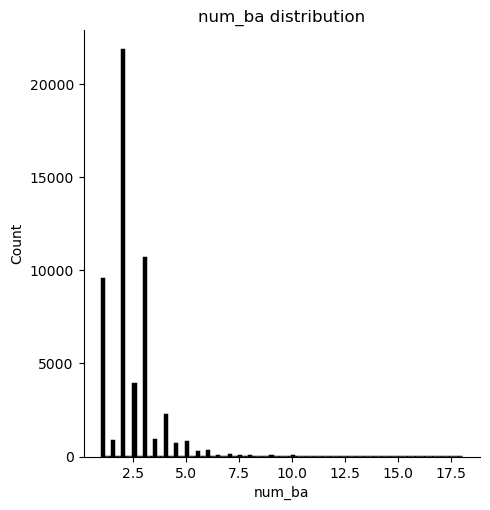

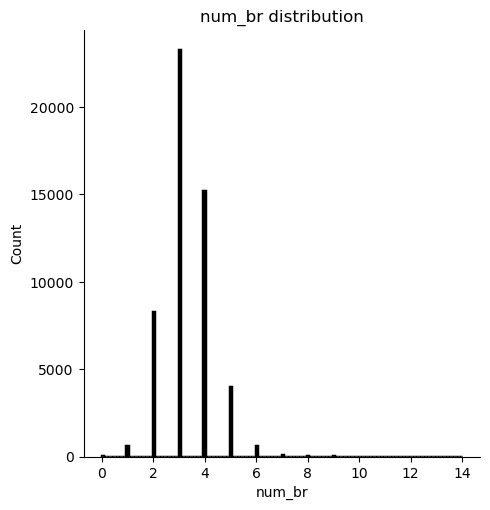

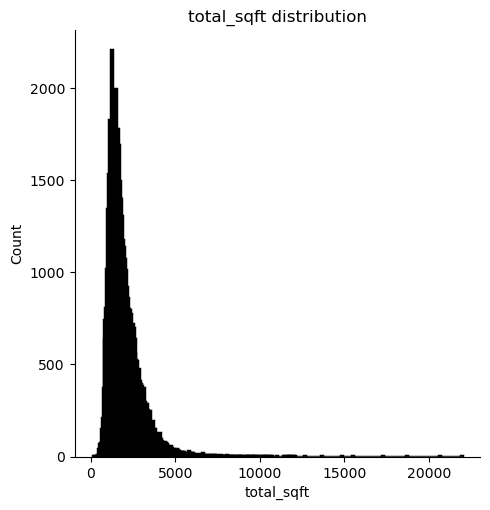

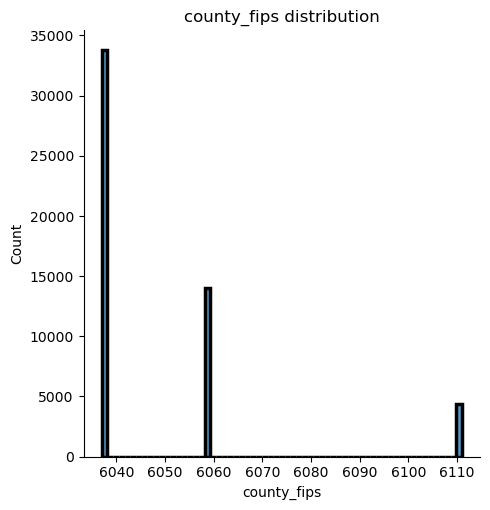

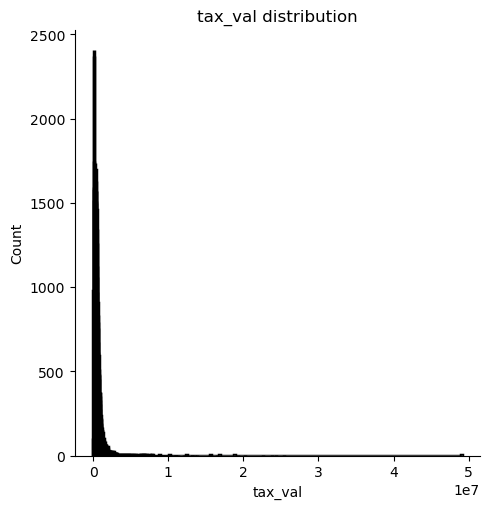

In [18]:
## visualising the data to look for outliers

for col in zil.columns:
    sns.displot(zil[col], palette = ['red', 'green'], linewidth=2.5)
    plt.title(f'{col} distribution')
    plt.show()

**TAKEAWAY : The tax value column appears to have a low number of major outliers, and is the only column with such. The county graphs are right-skewed, but there are only 3 counties included to begin with. The others are relatively normally distributed, though the date of sale shows a spike at the beginning of the year.**

 &emsp;

In [19]:
# looking at outliers in tax_value

zil[zil.tax_val >= 2_000_000]

,num_ba,num_br,total_sqft,county_fips,tax_val
16,4.5,6.0,3870.0,6059,2040000.0
45,6.5,5.0,9586.0,6059,3624442.0
108,6.0,3.0,4664.0,6037,2157425.0
126,4.0,5.0,4436.0,6059,2249017.0
170,6.0,6.0,3659.0,6037,2010195.0
...,...,...,...,...,...
52265,2.0,4.0,1224.0,6037,2040652.0
52314,6.0,5.0,5280.0,6037,4809000.0
52358,3.0,3.0,1687.0,6037,2000000.0
52360,6.0,5.0,5350.0,6037,2300797.0


In [20]:
# pc of outliers for tax value

(1403 / 52442) * 100

2.675336562297395

**If setting the tax value at $2 million as the cutoff for outliers, then we eliminate 2.67pc of the data. This is deemed insignificant.**

In [21]:
# keeping homes with a tax value of 2_000_000 or less

zil = zil[zil.tax_val <= 2_000_000]
zil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50735 entries, 0 to 52440
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   num_ba       50735 non-null  float64
 1   num_br       50735 non-null  float64
 2   total_sqft   50735 non-null  float64
 3   county_fips  50735 non-null  int64  
 4   tax_val      50735 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 2.3 MB


**After tidying, there are 50 937 rows and 6 columns.**

 &emsp;

### Now it's time to split into train, validate and test subsets.
## EXPLORE.

### Hypotheses


1.  
$H_{0}$ : The total square feet of the property has no influence on tax value.  
$H_{a}$ : The total square feet of the property has an influence on tax value.  


2.  
$H_{0}$ : The number of bathrooms has no influence on tax value.  
$H_{a}$ : The number of bathrooms has an influence on tax value.  


3.   
$H_{0}$ : The number of bedrooms has no influence on tax value.  
$H_{a}$ : The number of bedrooms has an influence on tax value.  


4.   
$H_{0}$ : County of property has no influence on tax value.  
$H_{a}$ : County of property has an influence on tax value.  




 &emsp;

In [22]:
train, val, test = project_2_prepare_zillow_2017.tts_zillow(zil)
train.shape, val.shape, test.shape

((28411, 5), (12177, 5), (10147, 5))

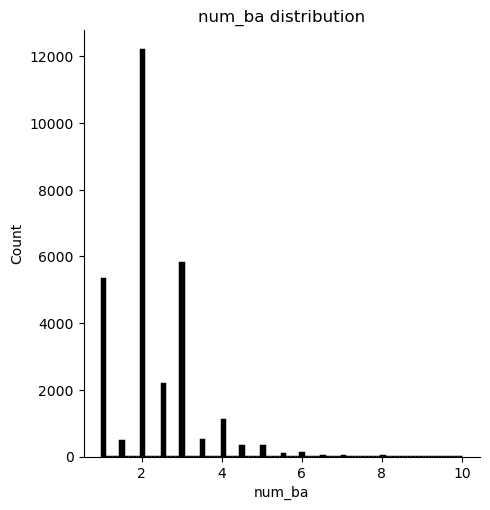

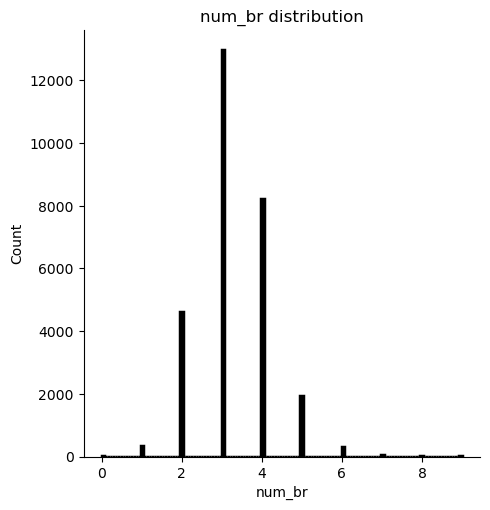

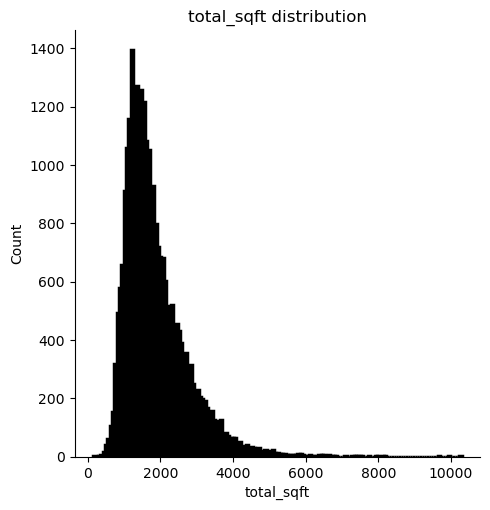

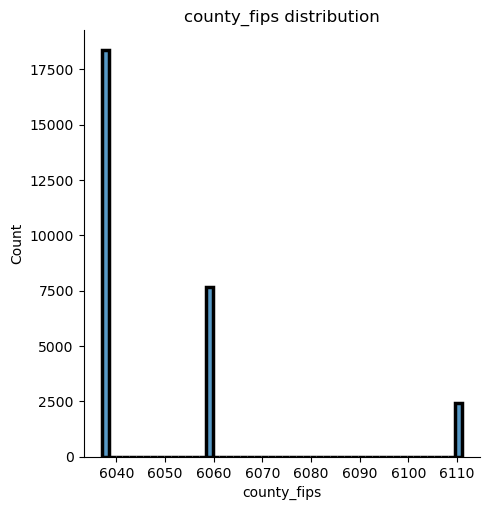

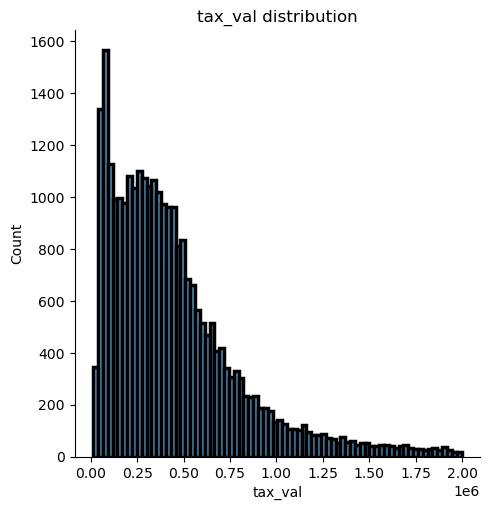

In [23]:
## visualising the data after cleaning

for col in train.columns:
    sns.displot(train[col], palette = ['red', 'green'], linewidth=2.5)
    plt.title(f'{col} distribution')
    plt.show()

 &emsp;

### Explore : Visualisation & Statistical Testing

In [24]:
# making a variable to contain the continuous data

con_var = ['tax_val', 'total_sqft']

disc_var = ['county_fips', 'num_ba', 'num_br']

# not sure if this is needed

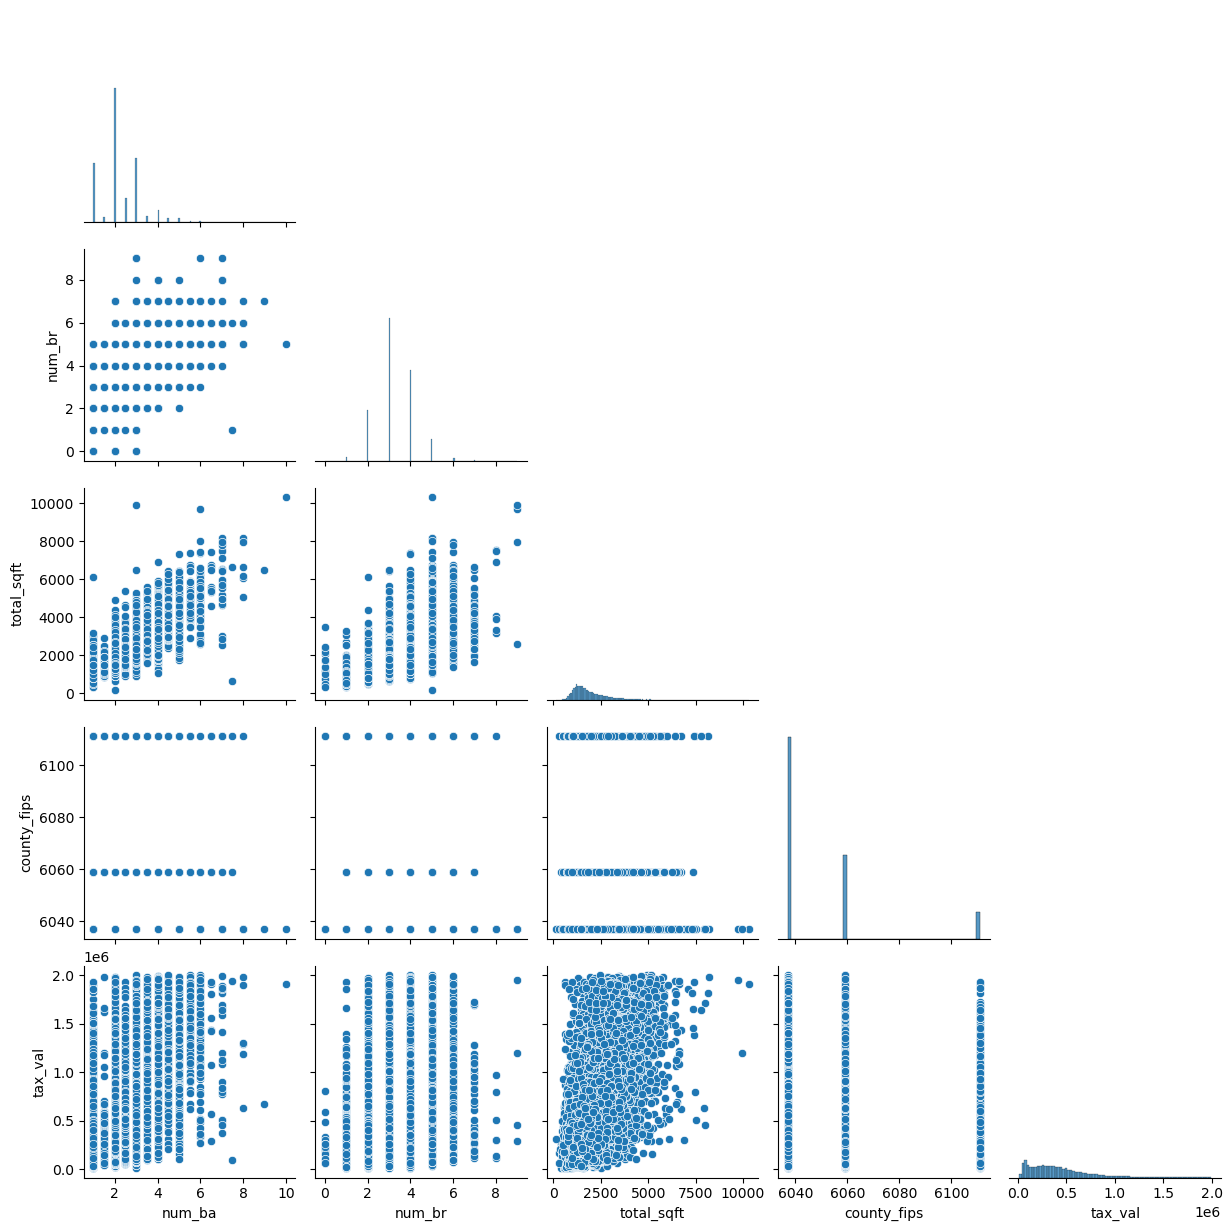

In [25]:
## looking at correlation

sns.pairplot(data = train, corner = True)
plt.show()

In [26]:
# looking at correlation

# this computes pairwise correlation of columns

train_corr = train.corr()
train_corr

,num_ba,num_br,total_sqft,county_fips,tax_val
num_ba,1.000000,0.630670,0.836555,0.138586,0.516794
num_br,0.630670,1.000000,0.636355,0.151115,0.285905
total_sqft,0.836555,0.636355,1.000000,0.148769,0.579507
county_fips,0.138586,0.151115,0.148769,1.000000,0.099734
tax_val,0.516794,0.285905,0.579507,0.099734,1.000000


**Takeaway :**   
**Correletion is strong between total_sqft and num_ba.**  

**Correlation is moderate between tax_val and num_ba, tax_val and total_sqft, num_ba and num_br.**  

**Correlation is low for tax_val and num_br, county_fips and num_br, county_fips and num_ba, county_fips and total_sqft.**  

**Correlation is very low for county_fips and tax_val.**  

 &emsp;

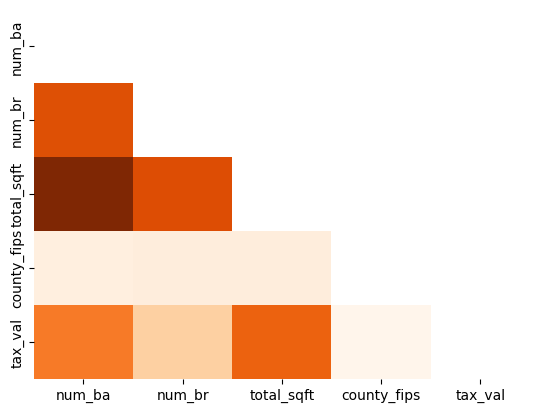

<Figure size 1500x1500 with 0 Axes>

In [27]:
# make a heatmap of con_corr

sns.heatmap(train.corr(), cmap = 'Oranges', cbar=False, annot_kws = {'fontsize' : 8}, mask = np.triu(train.corr()))

plt.figure(figsize = (15,15)) 

plt.show()

 &emsp;

### Question 1 : Does the total square footage of the home have a relationship to its tax value ?

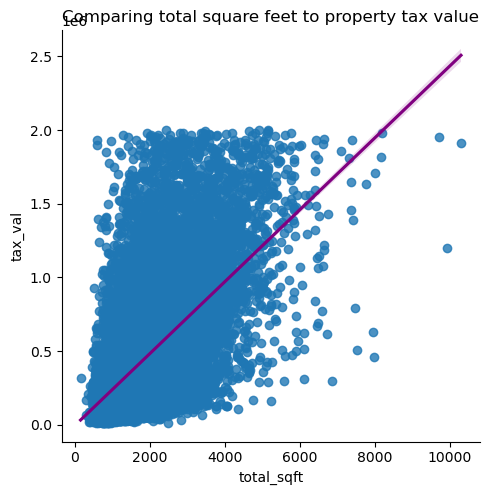

In [28]:
# plot the 'area_sqft' against target variable 'tax_value'

sns.lmplot(x = 'total_sqft', y = 'tax_val', data = train, line_kws =  {'color': 'purple'})
plt.title('Comparing total square feet to property tax value')
plt.show()


 &emsp;

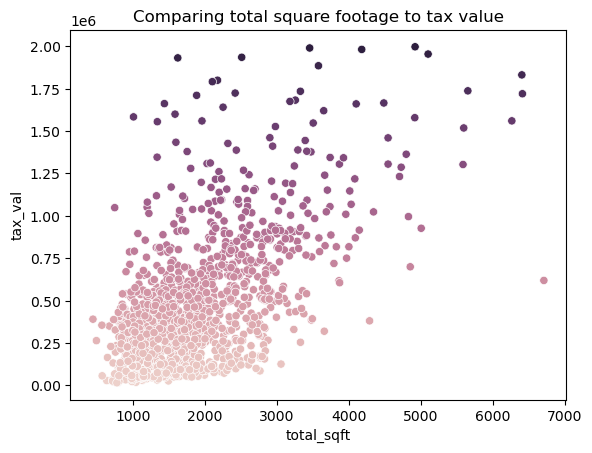

In [29]:
# plot the 'total_sqft' against target variable 'tax_value'

sns.scatterplot(x = 'total_sqft', y = 'tax_val', hue = 'tax_val', data = train.sample(1200))
plt.title('Comparing total square footage to tax value')

# removing the legend
plt.legend([],[], frameon = False)

plt.show()


**Takeaway :**  

**Looking at the scatterplot comparing the total square footage of the property to its tax value, it would appear that the majority of properties have total squre footage of less than 3000 sq ft, with the majority of these having a tax value of $1 million or less.**  

**Overall, the data appears to be relatively normally distributed.** 

 &emsp;

### Corresponding statistical test : total square footage to property tax value.

In [30]:
# setting the alpha value to 0.05

α = 0.05

In [31]:
# Use Pearson's R test (normally distribtued data) to calculate the correlation coefficient 
# and the p-value of total_sqft against tax_val

r_sf, p_value_sf = pearsonr(train.total_sqft, train.tax_val)
print(f'Correlation coefficient for property square footage and tax value: {round(r_sf, 5)}.\nP-value : {p_value_sf}.')


Correlation coefficient for property square footage and tax value: 0.57951.
P-value : 0.0.


**Takeaway :**
    
**Here, we used the Pearson's R statistical test, given that the data appeared relatively normally distributed.**  

**The test returns a coorelation coefficient of 0.58032, indicating moderate correlation. The p-value is 0, which would mean that we reject the null hypothesis : This indicates that there is a relationship between property total square footage and tax value.**

 &emsp;

### Question 2 : Does the number of bathrooms in the home have a relationship to its tax value ?

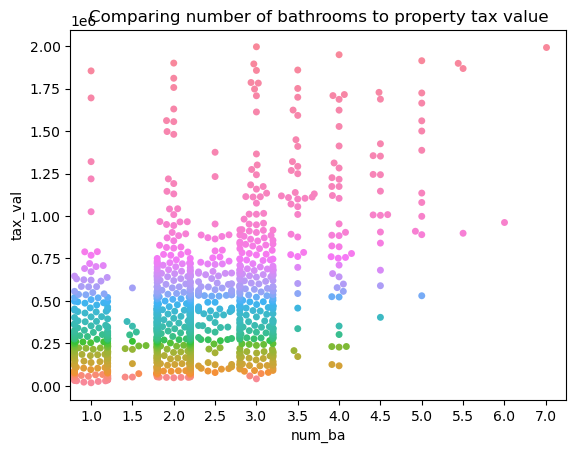

In [32]:
# plot the 'num_br' against target variable 'tax_value'

sns.swarmplot(x = 'num_ba', y = 'tax_val', data = train.sample(1200), hue = 'tax_val')
plt.title('Comparing number of bathrooms to property tax value')

# removing the legend
plt.legend([],[], frameon = False)

plt.show()


**Takeaway :**   

**Looking at the scatterplot comparing number of bathrooms to property tax value, it would appear that having 3 bathrooms leads the pack in driving tax value overall.**

**Overall, the data does not appear to be normally distributed.**

 &emsp;

### Corresponding statistical test : number of bathrooms to property tax value.

In [33]:
# checking variance between number of bedrooms and tax value

(train.num_ba).var(), (train.tax_val).var()

(0.8484843422745363, 127267990802.22897)

**Variance is hugely different.**

In [34]:
t_ba, p_ba = stats.ttest_ind(train.num_ba, train.tax_val, equal_var = False)
t_ba, p_ba

(-211.38187741938697, 0.0)

In [35]:
# print statement for the t-test
α = 0.5

if p_ba > α :
    print('We fail to reject the null hypothesis.')
elif t_ba < 0:
    print(f'We fail to reject the null hypothesis ; T-statistic of {round(t_ba, 3)}.')
else:
    print('We reject the null hypothesis.')

We fail to reject the null hypothesis ; T-statistic of -211.382.


**Takeaway :**
    
**Here, we used a two-tailed, independent T-test, given that the data consisted of discrete (number of bathrooms) and continuous (tax value) variables.**  

**The test returned a very low (-211.64) T-statistic, indicating that there is a highly significant difference in the relationship between the two. Because the T-statistic is so low, this would mean that that we would fail to reject the null hypothesis : This indicates that there is a only a very distant relationship between number of bathrooms and tax value.**

 &emsp;

### Question 3 : Does the number of bedrooms in the home have a relationship to its tax value ?

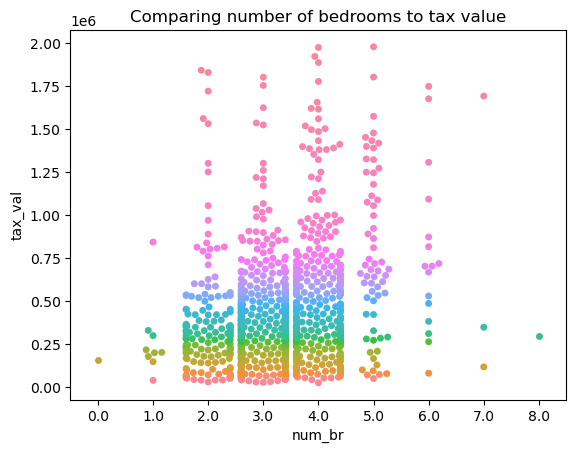

In [36]:
# plot the 'num_br' against target variable 'tax_value'

sns.swarmplot(x = 'num_br', y = 'tax_val', hue = 'tax_val', data = train.sample(1000))
plt.title('Comparing number of bedrooms to tax value')

# removing the legend
plt.legend([],[], frameon = False)

plt.show()


**Takeaway :**  

**The above scatterplot shows that hosues with 3 to 5 bedrooms are most common, followed by houses with 2 bedrooms. The tax value reaches highest for houses with 3 or 4 bedrooms, yet the overall relationship between number of bedrooms in relation to tax value appears rather week ; it would, almost, if read incorrectly, appear to indicate that having bedrooms drives down the tax value.**

**Overall, the data does not appear to be normally distributed.**

 &emsp;

### Corresponding statistical test : number of bedrooms to property tax value : independent, 2-tailed T-test

In [37]:
# checking variance between number of bedrooms and tax value

(train.num_br).var(), (train.tax_val).var()

(0.8302929081251382, 127267990802.22897)

**Variance is hugely different.**

In [38]:
t_br, p_br = stats.ttest_ind(train.num_br, train.tax_val, equal_var=False)
t_br, p_br

(-211.381388200861, 0.0)

In [39]:
# print statement for the t-test

if p_br > α :
    print('We fail to reject the null hypothesis.')
elif t_br < 0:
    print(f'We fail to reject the null hypothesis ; T-statistic of {round(t_br, 3)}.')
else:
    print('We reject the null hypothesis.')

We fail to reject the null hypothesis ; T-statistic of -211.381.


**Takeaway :**
    
**Here, we used a two-tailed, independent T-test, given that the data consisted of discrete (number of bedrooms) and continuous (tax value) variables.**  

**The test returned a very low (-211.64) T-statistic, indicating that there is a highly significant difference in the relationship between the two. Because the T-statistic is so low, this would mean that that we would fail to reject the null hypothesis : This indicates that there is a only a very distant relationship between number of bedrooms and tax value.**

 &emsp;

### Question 4 : Does the county of the home have a relationship to the tax value ?

In [40]:
# # plot the 'num_br' against target variable 'tax_value'

# sns.swarmplot(x = 'county_fips', y = 'tax_val', hue = 'tax_val', data = train.sample(1000))
# plt.title('Comparing county in which property is located to tax value')

# # modifying the legend
# plt.legend(['6037 : LA County', '6059 : Orange County', '6111 : Ventura County'], 
#            bbox_to_anchor = (1.03, 1), title = 'County FIPS Codes', title_fontsize = 14)

# plt.show()

# # 6037  = LA County
# # 6059 = Orange County
# # 6111 = Ventura County

**Takeaway :**

**The majority of single-family homes in Los Angeles County tend towards a lower tax value overall, but LA County single-family home tax value also reaches the highest. Ventura County (6111) is relatively equally distributed below a tax value of about $1 million, with a few outliers at much higher values. Orange County (6059), is, like LA County, heavier on the lower tax values, but its lowest tax value is higher than LA County's lowest.**  

**Overall, the data does not appear to be normally distributed.**

 &emsp;

### Corresponding statistical test : location of property to property tax value : Independent T-test

In [41]:
# checking variance between number of bedrooms and tax value

(train.county_fips).var(), (train.tax_val).var()

(445.9981084661018, 127267990802.22897)

**Variance is hugely different.**

In [42]:
t_fips, p_fips = stats.ttest_ind(train.county_fips, train.tax_val, equal_var=False)
t_fips, p_fips

(-208.52481156424864, 0.0)

In [43]:
# print statement for the t-test

if p_fips > α :
    print('We fail to reject the null hypothesis.')
elif t_fips < 0:
    print(f'We fail to reject the null hypothesis ; T-statistic of {round(t_fips, 3)}.')
else:
    print('We reject the null hypothesis.')

We fail to reject the null hypothesis ; T-statistic of -208.525.


**Takeaway :**
    
**Here, we used a two-tailed, independent T-test, given that the data consisted of discrete (county FIPS code) and continuous (tax value) variables.**  

**The test returned a very low (-208.64) T-statistic, indicating that there is a highly significant difference in the relationship between the two. Because the T-statistic is so low, this would mean that that we would fail to reject the null hypothesis : This indicates that there is a only a very distant relationship between the county FIPS code and the tax value.**

 &emsp;

## Overall Exploration Takeaways

**Visually, the data would seem to indicate a range of correlations and distributions between the feature variables and the target variable of property tax value ('tax_val'). For this reason, both Independent T-tests and a Pearson's R test were run.** 

**Statistical testing using Independent, 2-tailed T-tests on each of the discrete feature values (number of bedrooms, number of bathrooms, county of property) indicates that there is very little relationship between property tax value and number of bedrooms or number of bathrooms or county FIPS code.**   

**There is a moderate correlation (correlation coefficient of 0.58) between total square footage of the home and its tax value. Given the continuous category of both variables, the Pearson's R test was used here.**

**Moving forward, we will not drop any of the features, because of the limited number and too similar of statistical results.**

 &emsp;

 &emsp;

## Feature Engineering

**Target variable (y-value) is 'tax_val'. Do not scale it.**

In [44]:
train.head()

,num_ba,num_br,total_sqft,county_fips,tax_val
20986,3.0,3.0,2521.0,6037,464525.0
17998,2.5,3.0,2347.0,6059,879359.0
40409,2.0,3.0,1256.0,6037,84214.0
13509,2.0,3.0,1231.0,6037,56483.0
29555,2.0,3.0,1422.0,6037,125389.0


In [45]:
# finding the SelectKBest

project_2_zillow_skbest_rfe_functions.select_best(train, ['total_sqft', 'num_ba', 'num_br'], 'tax_val', 2)

Index(['total_sqft', 'num_ba'], dtype='object')

**Takeaway : The SelectKBest statistical test shows that total square footage of the house and its number of bathrooms have the closest relationship to the target variable of tax value.**

 &emsp;

In [46]:
# finding the RFE
# not scaling any of the columns

rfe = project_2_zillow_skbest_rfe_functions.rfe_function(train, 2, 'tax_val', [])
rfe

,ranking,feature
0,1,num_ba
1,1,num_br
3,2,county_fips
2,3,total_sqft


**Takeaway : The RFE statistical test shows that the number of bedrooms in the house and the number of bedrooms  have the closest relationship to the target variable of tax value.**

 &emsp;

In [47]:
# split train, val, test into X_train, X_val, X_test and y-train, etc

# y_train is only our target

# X_train is everything except for tax value

X_train = train.drop(columns = ['tax_val'])
y_train = train['tax_val']


X_val = val.drop(columns = ['tax_val'])
y_val = val['tax_val']


X_test = test.drop(columns = ['tax_val'])
y_test = test['tax_val']


In [48]:
X_train.head()

,num_ba,num_br,total_sqft,county_fips
20986,3.0,3.0,2521.0,6037
17998,2.5,3.0,2347.0,6059
40409,2.0,3.0,1256.0,6037
13509,2.0,3.0,1231.0,6037
29555,2.0,3.0,1422.0,6037


 &emsp;

## Linear Regression

In [49]:
# transforming y_train, y_val into DFs to allow for Linear Regression modelling

y_train = pd.DataFrame(y_train)
y_val = pd.DataFrame(y_val)

# assuring that it worked
y_train.head(3)

,tax_val
20986,464525.0
17998,879359.0
40409,84214.0


In [50]:
# finding the median of y_train & y_val

tax_pred_median = round(y_train['tax_val'].median())

# adding the predicted median column onto the y_ DFs
y_train['tax_val_pred_median'] = tax_pred_median
y_val['tax_val_pred_median'] = tax_pred_median

y_train.head()


,tax_val,tax_val_pred_median
20986,464525.0,364192
17998,879359.0,364192
40409,84214.0,364192
13509,56483.0,364192
29555,125389.0,364192


In [51]:
# finding the mean of y_train & y_val

tax_pred_mean = round(y_train['tax_val'].mean())

# adding the predicted mean column onto the y_ DFs
y_train['tax_val_pred_mean'] = tax_pred_mean
y_val['tax_val_pred_mean'] = tax_pred_mean

y_train.head()


,tax_val,tax_val_pred_median,tax_val_pred_mean
20986,464525.0,364192,447390
17998,879359.0,364192,447390
40409,84214.0,364192,447390
13509,56483.0,364192,447390
29555,125389.0,364192,447390


In [52]:
# Compute the RMSE comparing actual tax_val to tax_pred_mean.

rmse_train_mean = mean_squared_error(y_train['tax_val'], y_train['tax_val_pred_mean']) ** 0.5

rmse_val_mean = mean_squared_error(y_val['tax_val'], y_val['tax_val_pred_mean']) ** 0.5


print(f'The RMSE of the train dataset on the mean is {round(rmse_train_mean)} USD.')
print(f'The RMSE of the validate dataset on the mean is {round(rmse_val_mean)} USD.')

The RMSE of the train dataset on the mean is 356740 USD.
The RMSE of the validate dataset on the mean is 356668 USD.


In [53]:
# Compute the RMSE comparing actual tax_val to tax_pred_median.

rmse_train_med = mean_squared_error(y_val['tax_val'], y_val['tax_val_pred_median']) ** 0.5

rmse_val_med = mean_squared_error(y_val['tax_val'], y_val['tax_val_pred_median']) ** 0.5


print(f'The RMSE of the train dataset on the median is {round(rmse_train_med)} USD.')
print(f'The RMSE of the validate dataset on the median is {round(rmse_val_med)} USD.')

The RMSE of the train dataset on the median is 366245 USD.
The RMSE of the validate dataset on the median is 366245 USD.


**Takeaway : The Root Mean Square Error of the mean on the training dataset (356,740 USD) was lower than the RMSE of the median on the train dataset, so we will be setting the RMSE of the mean as the baseline.**

 &emsp;

In [54]:
# setting the baseline to equal 'rmse_train_mean'

y_train['baseline'] = round(rmse_train_mean)
y_train.head()

,tax_val,tax_val_pred_median,tax_val_pred_mean,baseline
20986,464525.0,364192,447390,356740
17998,879359.0,364192,447390,356740
40409,84214.0,364192,447390,356740
13509,56483.0,364192,447390,356740
29555,125389.0,364192,447390,356740


In [55]:
# dropping columns that are no longer necessary 

# y_train = y_train.drop(columns = ['tax_val_pred_median', 'tax_val_pred_mean', 'baseline_tax_val'])

y_train = y_train.drop(columns = ['tax_val_pred_median', 'tax_val_pred_mean'])
y_train.head()

,tax_val,baseline
20986,464525.0,356740
17998,879359.0,356740
40409,84214.0,356740
13509,56483.0,356740
29555,125389.0,356740


 &emsp;

 &emsp;

## MODELLING : Ordinary Least Squares 

In [56]:
# fitting the OLS model to 'total_sqft' against 'tax_val'
ols_model = LinearRegression().fit(train[['total_sqft']], train[['tax_val']])

# adding the yhat column to the train DF
train['yhat'] = ols_model.predict(train[['total_sqft']])

train.head(3)

,num_ba,num_br,total_sqft,county_fips,tax_val,yhat
20986,3.0,3.0,2521.0,6037,464525.0,610248.807931
17998,2.5,3.0,2347.0,6059,879359.0,567813.790363
40409,2.0,3.0,1256.0,6037,84214.0,301741.352621


In [57]:
# compute the y-hat baseline from 'tax_val'

train['yhat_baseline'] = round(train['tax_val'].mean())
train.head(3)

,num_ba,num_br,total_sqft,county_fips,tax_val,yhat,yhat_baseline
20986,3.0,3.0,2521.0,6037,464525.0,610248.807931,447390
17998,2.5,3.0,2347.0,6059,879359.0,567813.790363,447390
40409,2.0,3.0,1256.0,6037,84214.0,301741.352621,447390


In [58]:
# setting a baseline

baseline = train['tax_val'].mean()
train['baseline'] = baseline

In [59]:
# calculating the residuals, to detrmine how far the baseline is from the actual

train['yhat_residual'] = train['yhat'] - train['tax_val']
train['baseline_res'] = train['yhat_baseline'] - train['tax_val'] 

train.head()

,num_ba,num_br,total_sqft,county_fips,tax_val,yhat,yhat_baseline,baseline,yhat_residual,baseline_res
20986,3.0,3.0,2521.0,6037,464525.0,610248.807931,447390,447389.989546,145723.807931,-17135.0
17998,2.5,3.0,2347.0,6059,879359.0,567813.790363,447390,447389.989546,-311545.209637,-431969.0
40409,2.0,3.0,1256.0,6037,84214.0,301741.352621,447390,447389.989546,217527.352621,363176.0
13509,2.0,3.0,1231.0,6037,56483.0,295644.367338,447390,447389.989546,239161.367338,390907.0
29555,2.0,3.0,1422.0,6037,125389.0,342225.334899,447390,447389.989546,216836.334899,322001.0


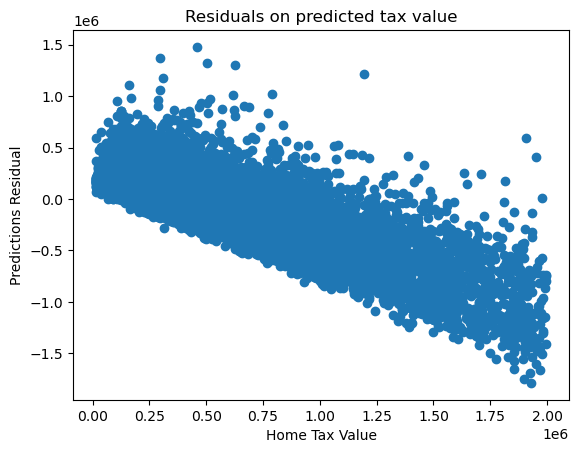

In [60]:
## make a scatter plot of the model's prediction on the actual tax value in relation to the predicted

plt.scatter(x = train['tax_val'], y = train['yhat_residual'])

plt.xlabel('Home Tax Value')
plt.ylabel('Predictions Residual')
plt.title('Residuals on predicted tax value')
plt.show()

**Takeaway : We can see that there is a gradual, rather consistent, downslope for the residuals on the predicted tax value a the tax value of the home increases.**

 &emsp;

In [61]:
# compute the Sum of Squared Errors (multiplying by the number of entries in the DF)

sse = mean_squared_error(train['tax_val'], train['yhat']) * len(train)
                               
sse_baseline = mean_squared_error(train['tax_val'], train['yhat_baseline']) * len(train)


print(f'The sum of squared errors of the train dataset is {sse}.') 
print(f'The SSE of the train dataset baseline is {sse_baseline}.') 

The sum of squared errors of the train dataset is 2401434703025106.0.
The SSE of the train dataset baseline is 3615683618691319.0.


In [62]:
# the mean of squared errors


mse = mean_squared_error(train['tax_val'], train['yhat'])
mse_baseline = mean_squared_error(train['tax_val'], train['yhat_baseline']) 

print(f'The mean of squared errors of the train dataset is {mse}.') 
print(f'The MSE of the train dataset baseline is {mse_baseline}.') 

The mean of squared errors of the train dataset is 84524821478.48038.
The MSE of the train dataset baseline is 127263511269.97708.


In [63]:
# the root of mean of squared errors


rmse = sqrt(mean_squared_error(train['tax_val'], train['yhat']))
rmse_baseline = sqrt(mean_squared_error(train['tax_val'], train['yhat_baseline']))

print(f'The root of mean of squared errors of the train dataset is {round(rmse, 4)}.') 
print(f'The RMSE of the train dataset baseline is {round(rmse_baseline, 4)}.') 

The root of mean of squared errors of the train dataset is 290731.5282.
The RMSE of the train dataset baseline is 356740.1173.


In [64]:
evs = explained_variance_score(train['tax_val'], train['yhat'])

print(f'The explained variance of the model from the actual data is {round(evs, 4)}.')
# how effectively the trend line from the modelling is describing the data

The explained variance of the model from the actual data is 0.3358.


In [65]:
# finding the best model for the above metrics

train_eval = pd.DataFrame(np.array(['SSE', 'MSE', 'RMSE']), columns = ['metric_used'])

train_baseline_eval = pd.DataFrame(np.array(['SSE_baseline', 'MSE_baseline', 'RMSE_baseline']), columns = ['metric_used'])

train_eval['model_error'] = np.array([sse, mse, rmse])

train_baseline_eval['model_error'] = np.array([sse_baseline, mse_baseline, rmse_baseline])

print(train_eval)
print()
print(train_baseline_eval)

  metric_used   model_error
0         SSE  2.401435e+15
1         MSE  8.452482e+10
2        RMSE  2.907315e+05

     metric_used   model_error
0   SSE_baseline  3.615684e+15
1   MSE_baseline  1.272635e+11
2  RMSE_baseline  3.567401e+05


In [66]:
# visualising the amount of error in a DF

train_eval['error_amount'] = train_eval['model_error'] - train_baseline_eval['model_error']
train_eval.head()

,metric_used,model_error,error_amount
0,SSE,2.401435e+15,-1.214249e+15
1,MSE,8.452482e+10,-4.273869e+10
2,RMSE,2.907315e+05,-6.600859e+04


**Takeaway : The SSE has the smallest model error amount, slightly below the baseline. This metric, because it respects the outliers, is deemed the most appropriate.**

 &emsp;

 &emsp;

##  MODELLING : Lasso + Lars

In [67]:
#establishing linear regression model

lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [68]:
# making dummies
zil = pd.get_dummies(zil, columns = ['num_ba', 'num_br', 'county_fips'])
zil.head(1)

,total_sqft,tax_val,num_ba_1.0,num_ba_1.5,num_ba_2.0,num_ba_2.5,num_ba_3.0,num_ba_3.5,num_ba_4.0,num_ba_4.5,...,num_br_5.0,num_br_6.0,num_br_7.0,num_br_8.0,num_br_9.0,num_br_10.0,num_br_11.0,county_fips_6037,county_fips_6059,county_fips_6111
0,3100.0,1023282.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [69]:
# splitting into train, val, test based on zil DF with dummies

train, val, test = project_2_prepare_zillow_2017.tts_zillow(zil)
train.shape, val.shape, test.shape

((28411, 34), (12177, 34), (10147, 34))

In [70]:
# split train, val, test into X_train, X_val, X_test and y-train, etc
# X_train is everything except for tax value

X_train = train.drop(columns = ['tax_val'])
y_train = train['tax_val']


X_val = val.drop(columns = ['tax_val'])
y_val = val['tax_val']


X_test = test.drop(columns = ['tax_val'])
y_test = test['tax_val']
X_train.head(1)

,total_sqft,num_ba_1.0,num_ba_1.5,num_ba_2.0,num_ba_2.5,num_ba_3.0,num_ba_3.5,num_ba_4.0,num_ba_4.5,num_ba_5.0,...,num_br_5.0,num_br_6.0,num_br_7.0,num_br_8.0,num_br_9.0,num_br_10.0,num_br_11.0,county_fips_6037,county_fips_6059,county_fips_6111
20986,2521.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [71]:
# using Lasso + Lars model
lal = LassoLars(alpha = 0.13)

# fitting to 
lal.fit(X_train, y_train)

# predict on X_train
lal_pred = lal.predict(X_train)

In [72]:
# making a DF of the predictions based on y_train

prediction_df = pd.DataFrame({'actual' : y_train,
                              'lal_predictions' : lal_pred})
prediction_df.head(3)

,actual,lal_predictions
20986,464525.0,612385.923186
17998,879359.0,616866.295102
40409,84214.0,295212.633789


In [73]:
# get the square root of the rmse of the actual values and the predictions

lal_rmse = sqrt(mean_squared_error(prediction_df['lal_predictions'], prediction_df['actual']))
lal_rmse
# result is the magnitude of the error from the prediction (+ / -)

283163.99877798045

**Takeaway : The RMSE indicates a magnitude of error of about 238,164 from the Lasso + Lars prediction.**

In [74]:
# finding the mean of the y_train 

y_train.mean()

447389.9895463025

 &emsp;

 &emsp;

## MODELLING : Generalised Linear Model (TweedieRegressor)

In [75]:
# plotting to look at the data

plt.hist(y_train)

(array([7946., 7974., 5708., 3000., 1561.,  860.,  538.,  352.,  264.,
         208.]),
 array([  13199. ,  211604.2,  410009.4,  608414.6,  806819.8, 1005225. ,
        1203630.2, 1402035.4, 1600440.6, 1798845.8, 1997251. ]),
 <BarContainer object of 10 artists>)

**This distribution appears to be of the gamma type, so we will set our GLM to the power the power of 2.**

In [76]:
# setting and fitting the TweedieRegressor

tweed = TweedieRegressor(power = 2)
tweed.fit(X_train, y_train)

TweedieRegressor(power=2)

In [77]:
# predicting on X_train
prediction_df['tweedie'] = tweed.predict(X_train)
prediction_df.head()

,actual,lal_predictions,tweedie
20986,464525.0,612385.923186,560522.651145
17998,879359.0,616866.295102,536048.363799
40409,84214.0,295212.633789,309620.448413
13509,56483.0,289918.804648,306060.196719
29555,125389.0,330363.659286,334334.280946


In [78]:
# cheking the error

tweed_rmse = sqrt(mean_squared_error(prediction_df['tweedie'], prediction_df['actual']))

tweed_rmse

362181.115726826

 &emsp;


**Now that we have realised 3 models, we will put them into a dataframe and compare the results.**

In [79]:
# making a DF of the 3 models (OLS, Lasso + Lars, TweedieRegressor)

pd.DataFrame({'Model' : ['Linear OLS', 'LassoLars','Tweedie Regressor'], 
              'RMSE' : [rmse, lal_rmse, tweed_rmse]})

,Model,RMSE
0,Linear OLS,290731.528181
1,LassoLars,283163.998778
2,Tweedie Regressor,362181.115727


In [80]:
# appending the OLS results onto the prediction_df DF

prediction_df['ols'] = ols_model.predict(train[['total_sqft']])
prediction_df.head()

,actual,lal_predictions,tweedie,ols
20986,464525.0,612385.923186,560522.651145,610248.807931
17998,879359.0,616866.295102,536048.363799,567813.790363
40409,84214.0,295212.633789,309620.448413,301741.352621
13509,56483.0,289918.804648,306060.196719,295644.367338
29555,125389.0,330363.659286,334334.280946,342225.334899


In [81]:
# appending the baseline results onto the dataframe

prediction_df['baseline'] = baseline
prediction_df.head()

,actual,lal_predictions,tweedie,ols,baseline
20986,464525.0,612385.923186,560522.651145,610248.807931,447389.989546
17998,879359.0,616866.295102,536048.363799,567813.790363,447389.989546
40409,84214.0,295212.633789,309620.448413,301741.352621,447389.989546
13509,56483.0,289918.804648,306060.196719,295644.367338,447389.989546
29555,125389.0,330363.659286,334334.280946,342225.334899,447389.989546


In [82]:
# finding the error cf the baseline

sqrt(mean_squared_error(prediction_df['actual'], prediction_df['baseline']))

356740.1172702293

**The output number shows (356,740 USD) that we beat the baseline (447,389 USD) in all of our models.**

 &emsp;

## USING THE BEST TWO MODEL ON THE VALIDATE DATASET

**The best models were found to be the Lasso + Lars model and the OLS model.**

In [83]:
# using Lasso + Lars model
lal2 = LassoLars(alpha = 0.13)

# fitting to 
lal2.fit(X_val, y_val)

# predict on X_train
lal_pred2 = lal2.predict(X_val)

In [84]:
# making a DF of the predictions based on y_train

val_preds = pd.DataFrame({'actual' : y_val,
                          'lal_val_preds' : lal_pred2})
val_preds.head(3)

,actual,lal_val_preds
17518,227350.0,564456.778449
20293,807123.0,435142.030683
30280,249447.0,382169.967528


In [85]:
# get the square root of the rmse of the actual values and the predictions

lal_rmse2 = sqrt(mean_squared_error(val_preds['lal_val_preds'], val_preds['actual']))
lal_rmse2
# result is the magnitude of the error from the prediction (+ / -)

284051.0084026474

In [86]:
# finding the mean of the y_train 

y_val.mean()

447396.9998357559

**Now that we've run the Lasso + Lars test on the validate dataset, we will compare the results with the training dataset.**

In [87]:
# make a DF of LL RMSE train and LL RMSE val

pd.DataFrame({'lasso_train_rmse' : [lal_rmse], 'lasso_val_rmse' : [lal_rmse2]})

,lasso_train_rmse,lasso_val_rmse
0,283163.998778,284051.008403


**TAKEAWAY :**  

**The RMSE of the Lasso + Lars model on the training dataset has an RMSE of 283,163 USD. On the validation (out-of-sample) dataset, the RMSE using Lasso + Lars is 284,051 USD, which is a minimal difference of only 888 USD more than on the training dataset.**   

**From this, we can see that the Lasso + Lars model is consistent in its predictions.**
 
 



 &emsp;

### Now we will run the validate dataset against the OLS Linear Regression model

In [88]:
# using OLS


# fitting the OLS model to 'total_sqft' against 'tax_val'
ols_model = LinearRegression().fit(val[['total_sqft']], val[['tax_val']])

# predicting on total_sqft after it's been fit
ols_val = ols_model.predict(val[['total_sqft']])


In [89]:
# looking at indexing of v_val

y_val.head()

17518    227350.0
20293    807123.0
30280    249447.0
3475     747560.0
45844    659438.0
Name: tax_val, dtype: float64

In [90]:
# resetting y_val index 

y_val.index.sort_values()

y_val.reset_index(drop = True, inplace = True)

y_val.head()

0    227350.0
1    807123.0
2    249447.0
3    747560.0
4    659438.0
Name: tax_val, dtype: float64

In [91]:
#making new df for ols validate

ols_df = pd.DataFrame(ols_val)
ols_df['y_val'] = y_val

ols_df.head()

,0,y_val
0,617103.701418,227350.0
1,439105.024839,807123.0
2,400945.200009,249447.0
3,573872.001136,747560.0
4,372687.608205,659438.0


In [92]:
# renaming the columns

ols_df.rename(columns = {0 : 'ols_val_preds', 'y_val' : 'actual'}, inplace = True)
ols_df.head(2)

,ols_val_preds,actual
0,617103.701418,227350.0
1,439105.024839,807123.0


In [93]:
# get the square root of the rmse of the actual values and the predictions

rmse2 = sqrt(mean_squared_error(ols_df['ols_val_preds'], ols_df['actual']))
rmse2


291991.2513010557

In [94]:
# vsualising the RMSE OLS DF

pd.DataFrame({'ols_train_rmse' : [rmse], 'ols_val_rmse' : [rmse2]})

,ols_train_rmse,ols_val_rmse
0,290731.528181,291991.251301


**TAKEAWAY :** 

**On the OLS model run on the validate dataset, the RMSE was 1260 USD higher than on the training dataset, a negligible difference.**  

**However, the error on the Lasso + Lars model was still smaller in both cases.**

 &emsp;


## MODELLING TAKEAWAYS

**In the modelling process, we used three different tests : OLS / Linear Regression, Lasso + Lars and the Generalised Linear Model (TweedieRegressor).**   

**The Ordinary Least Squares and the Lasso + Lars models had the best results as compared with the baseline for both the train and the validate datasets. The modelling results for the analysis of the validate dataset led it to be shown that neither model was overfit.**

**Overall, the Lasso + Lars had the most accurate results of the three tests, with an RMSE of 283,163 USD on the training dataset. On the validation (out-of-sample) dataset, the RMSE using Lasso + Lars was 284,051 USD, which is a minimal difference of only 888 USD more than on the training dataset.**   

 &emsp;

### Having determined the best model, here below is a histogram plotting the actual tax value to the predicted tax value, using the test dataset.

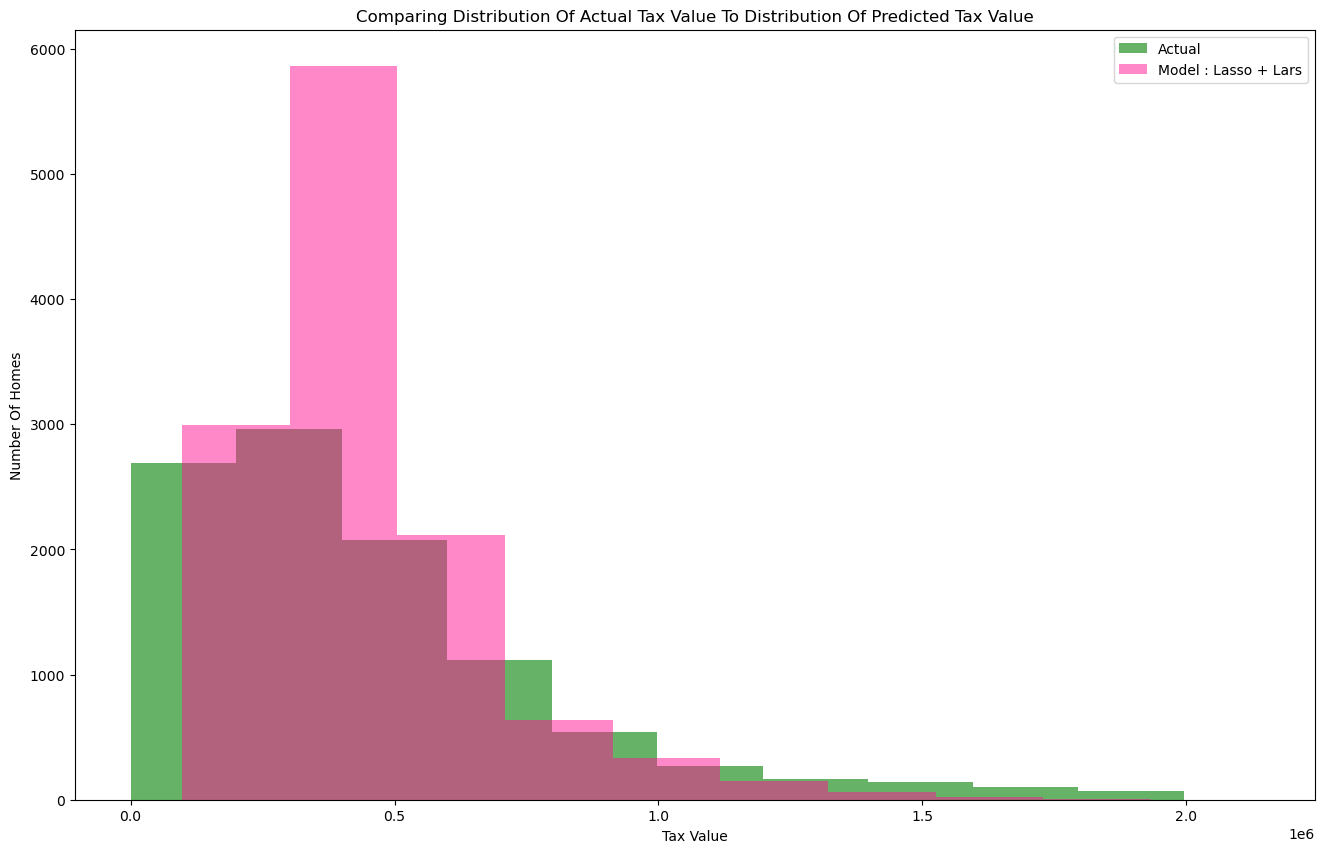

In [123]:
# plot to visualize actual vs predicted tax values

plt.figure(figsize = (16, 10))
plt.hist(y_test, color = 'green', alpha = 0.6, label= 'Actual')
plt.hist(lal_pred2, color = 'deeppink', alpha = 0.5, label = 'Model : Lasso + Lars')
plt.title('Comparing Distribution Of Actual Tax Value To Distribution Of Predicted Tax Value')

plt.xlabel('Tax Value')
plt.ylabel('Number Of Homes')
plt.legend()
plt.show()
